In [42]:
import numpy as np
import pandas as pd
import cv2
import glob
import time
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# some commonly used functions
def read_image(image_path):
    """
        read the image in the given path
        as cv2.imread returns BGR images, apply transformation to expected RGB
    """
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

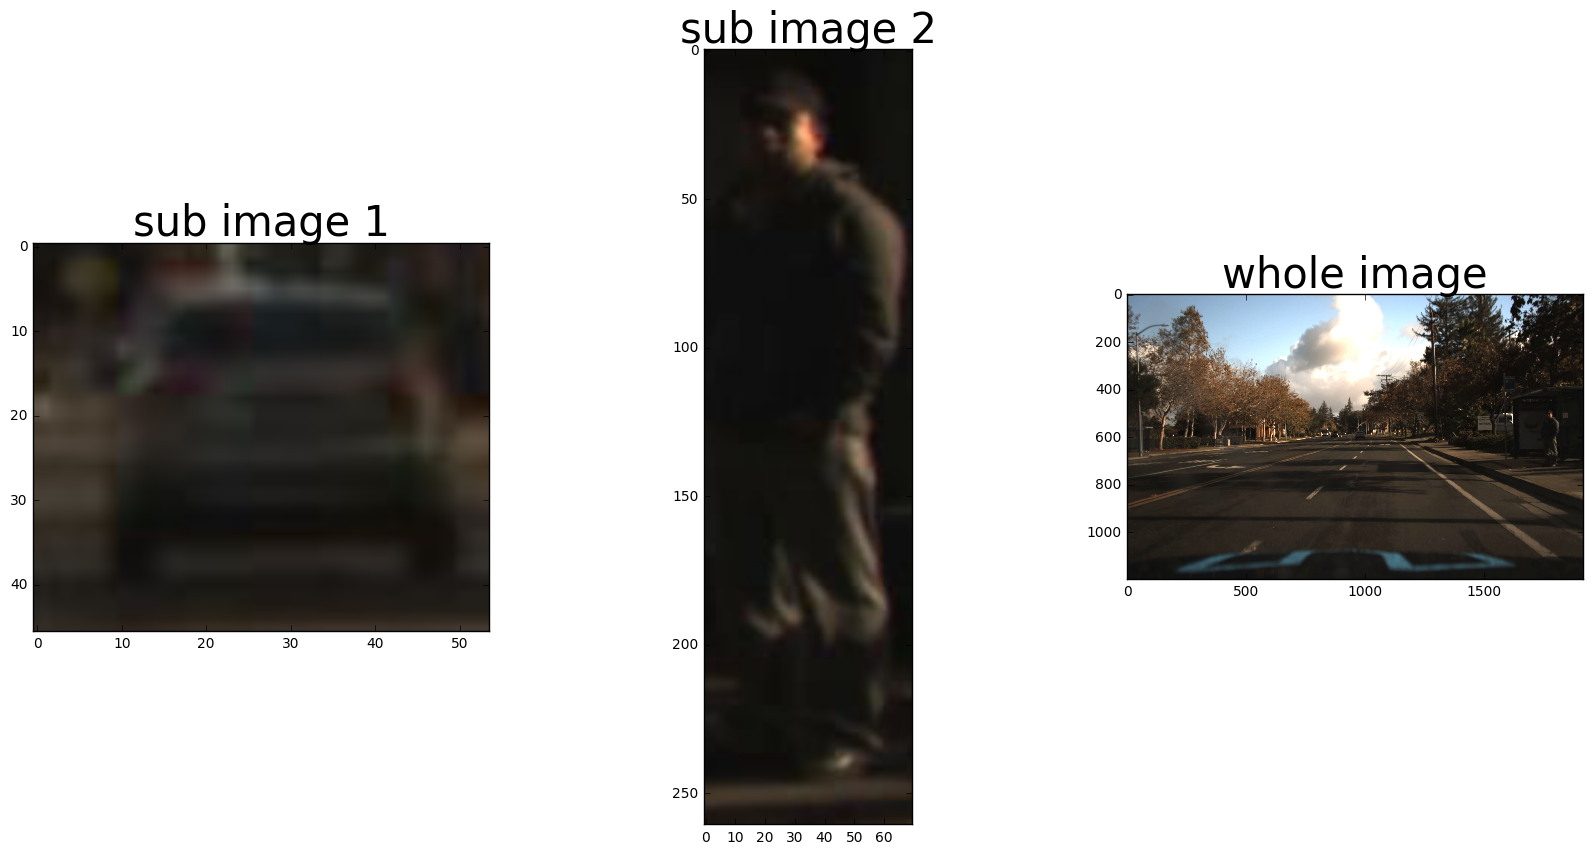

In [48]:
# create separate images from the annotated udacity data
base_path_read = './training/object-dataset/'
base_path_save = './training/generated/'
labels_file = base_path_read + 'labels.csv'
counter = 0

def extract_single_image(image, row):
    global counter
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    # crop_img = img[200:400, 100:300] # Crop from x, y, w, h -> 100, 200, 300, 400
    # NOTE: its img[y: y + h, x: x + w] and *not* img[x: x + w, y: y + h]
    cropped = image[ymin:ymax, xmin:xmax]
    file_name = 'image_' + str(counter) + '.jpg'
    counter += 1
    sub_dir = 'car/' if ((row['label'] == 'car') | (row['label'] == 'truck')) else 'notcar/'
    cv2.imwrite(base_path_save + sub_dir + file_name, cropped)

def extract_images():
    data = pd.read_csv(labels_file, 
                   names = ['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'occluded', 'label'],
                   delimiter = ' ')

    image_names = data.image_name.unique()
    for image_name in image_names:
        current = data[data.image_name == image_name]
        current.apply(lambda x: extract_image(read_image(base_path_udacity + image_name), x), axis=1)


In [17]:
# define methods for feature extraction

# create features based on the histograms of the individual color channels.
def color_histogram_features(image, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# spatial binning as discussed in the lectures.
def spatial_binning_features(image, size=(32, 32)):
    features = cv2.resize(image, size).ravel()
    return features


# create HOG features of an image as discussd in class
def hog_features(image, orient, pix_per_cell, cell_per_block):
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=False, feature_vector=True)
        return features


In [22]:
# define a rudimentary pipeline
car_images_path = './training/vehicles/*/*'
not_car_images_path = './training/non-vehicles/*/*'

# Define a function to extract features from a list of images
def extract_features(images, spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    
    features = []
    for image in images:
        # Apply bin_spatial() to get spatial color features
        spatial_features = spatial_binning_features(image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_histogram_features(image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))

    # Return list of feature vectors
    return features


# Read in car and non-car images
cars = [read_image(x) for x in glob.glob(car_images_path)]
not_cars = [read_image(x) for x in glob.glob(not_car_images_path)]
print(len(cars), len(not_cars))

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_features(cars, spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(not_cars, spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:', spatial, 'and', histbin, 'histogram bins')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

8792 9666
8792
9666
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
23.36 Seconds to train SVC...
Test Accuracy of SVC =  0.9499
My SVC predicts:  [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.]
0.00277 Seconds to predict 10 labels with SVC
